# **Trust Region Policy Optimization**

Policy gradient is based on gradient ascent, which is to update parameters by the first-order derivation. However, if the surface has a high curvature, we will make a relative large update to parameters, that is not stable.

TRPO limits the changes on the parameter within one iteration to stablize the policy update process, and make sure that the update is toward a better policy.

## **Minorize-Maximization Algorithm**

The Minorize-Maximization (MM) algorithm gives us the theoretical guarantees that the updates always result in improving the expected rewards. A simple one line explanation of this algorithm is that it iteratively maximizes a simpler lower bound function (lower bound with respect to the actual reward function), approximating the reward function locally.

<img src="img/mm_algorithm.png" width="800">  

The discounted reward can be expressed as,

$$\eta(\pi)=E_{\tau\sim\pi}[R(\tau)]=E_{\tau\sim\pi_{\theta}}[\sum_{t=1}^{\infty}\gamma^{t}r(s_t)]$$

As metioned in [reinforcement_learning_concept](https://github.com/kueiwen/reinforcement-learning/blob/main/reinforcement_learning_concept.ipynb), there are two function from Bellman equation: value function $V_{\pi}$ and action value function $Q_{\pi}$, here we introduce another function named advantage function $A_{\pi}$:

$$A_{\pi}(s,a)=Q_{\pi}(s,a)-V_{\pi}(s)$$

Advantage function calcuated the addtional action value if current state is $s$.

Then we can use advantage function to get how another policy $\tilde{\pi}$ is better than current policy $\pi$

$$\eta(\tilde{\pi})=\eta(\pi)+E_{\tau\sim\tilde{\pi}}[\sum_{t=1}^{\infty}\gamma^{t}A_{\tilde{\pi}}(s_t,a_t)]=\eta(\pi)+\sum_{s}\rho_{\tilde{\pi}}(s)\sum_{a}\tilde{\pi}(a|s)A_{\pi}(s,a)$$


where $\rho_{\pi}(s)$ is the probability distribution of states under policy $\pi$.



This equation implies that any policy update $\pi\to\tilde{\pi}$ that has a non-negative expected advantage at *every* state $s$, which mean that $\sum_{a}\tilde{\pi}(a|s)A_{\pi}(s,a)\geq0$ is guaranteed to increase the policy performance $\eta$ or keep the same.

However, it is hard to to use deterministic policy $\tilde{\pi}(s)=\text{arg}\max_{a}A(s,a)$ for all states to get a better policy that at least one state with positive advantage and others are zero, which is due to the difference between $\rho_{\tilde{\pi}}$ and $\rho_{\pi}$.

Therefore, here comes anther equation for local approximation of $\eta$,

$$L_{\pi}(\tilde{\pi})=\eta(\pi)+\sum_{s}\rho_{\tilde{\pi}}(s)\sum_{a}\tilde{\pi}(a|s)A_{\pi}(s,a)$$

The $L_{\pi}$ use the state probability disrtibution under $\pi$ rather than $\tilde{\pi}$.

And for any policy parameter $\theta_{0}$,

$$L_{\pi_{\theta_{0}}}(\pi_{\theta})=\eta(\pi_{\theta_{0}})$$

$$\nabla_{\theta}L_{\pi_{\theta_{0}}}(\pi_{\theta})|_{\theta=\theta_{0}}=\nabla_{\theta}\eta(\pi_{\theta})|_{\theta=\theta_{0}}$$

which implies that a small step $\pi_{\theta_0}\to\tilde{\pi}$ also contributes to $\eta$, but does not give us any guidance on how big of a step to take.

An policy updating schema is introduced to overcome this issue, called conservative policy iteration, which can provide explicit lower bounds on the improvement of $\eta$.

$$\pi_{\text{new}}(a|s)=(1-\alpha)\pi_{\text{old}}(a|s)+\alpha\pi^{\prime}(a|s)$$

where $\pi_{\text{old}}$ is current policy, and let $\pi^{\prime}=\arg\max_{\pi^{\prime}}L_{\text{old}}(\pi^{\prime})$.

And the lower bounds of improvement,

$$\eta(\pi_{\text{new}})\geq L_{\pi_{\text{old}}}(\pi_{\text{new}})-\frac{2\epsilon\gamma}{(1-\gamma)^2}\alpha^2$$

$$\text{where }\epsilon=\max_{s}|E_{a\sim\pi^{\prime}(a|s)}[A_{\pi}(s,a)]|$$

We can make this more applicable to pratical problem by replacing $\alpha$ with the distance between $\pi$ and $\tilde{\pi}$, we use total variance divergence $D_{\text{VT}}(p||q)=\frac{1}{2}\sum_{i}|p_i-q_i|$ for discrete probability distribution $p$ and $q$. So the distance between $\pi$ and $\tilde{\pi}$ will be,

$$D_{\text{VT}}^{\max}(\pi,\tilde{\pi})=\max_{a}D_{\text{VT}}(\pi(.|s)||\tilde{\pi}(.|s))$$

So if $\alpha=D_{\text{VT}}^{\max}(\pi,\tilde{\pi})$


$$\eta(\pi_{\text{new}})\geq L_{\pi_{\text{old}}}(\pi_{\text{new}})-\frac{4\epsilon\gamma}{(1-\gamma)^2}\alpha^2$$

$$\text{where }\epsilon=\max_{s,a}|A_{\pi}(s,a)|$$

Because $D_{\text{TV}}(p||q)^2\leq D_{\text{KL}}(p||q)$, the bound can be,

$$\eta(\pi_{\text{new}})\geq L_{\pi_{\text{old}}}(\pi_{\text{new}})-CD_{\text{KL}}^{\max}(\pi,\tilde{\pi})$$

$$\text{where }C=\frac{4\epsilon\gamma}{(1-\gamma)^2}\alpha^2$$

KL here represent KL divergence, which is to calculate the similarity of two distribution,  


$$D_{\text{KL}}(p,q)=\sum_{i}p_i\log(\frac{p_i}{q_i})$$

By conservative policy iteration, we can get a sequence of monotonically improved policies $\eta(\pi_0)\leq\eta(\pi_1)\leq\eta(\pi_2)\leq...$.   

Based on Minorize-Maximization (MM) algorithm, let surrogate function $M_i(\pi)=L_{\pi_{i}}(\pi)-CD_{\text{KL}}^{\max}(\pi_i,\pi)$, then,


$$\eta(\pi_{i+1})\geq M_i(\pi_{i+1})$$

$$\eta(\pi_{i})=M_i(\pi_{i})$$

$$\text{therefore  }\eta(\pi_{i+1})-\eta(\pi_{i})\geq M_i(\pi_{i+1})-M_i(\pi_{i})$$

By maximizing $M_i$ at each iteration, we can gaurantee that $\eta$ is non-decreasing.

***policy iteration algorithm guaranteeing non-decreasing expected return $\eta$***

---
Initialize $\pi_{0}$

**repeat**  
    $\quad$ Computing all advantage values $A_{\pi_{i}}(s,a)$      
    $\quad$ Solve the constrained optimization problem        
    $\quad\quad \pi_{i+1}=\arg\max_{\pi}[L_{\pi_{i}}(\pi)-CD_{\text{KL}}^{\max}(\pi_i,\pi)]$      
            $\quad\quad$ where $C=4\epsilon\gamma/(1-\gamma)^2$       
            $\quad\quad\quad$ and $L_{\pi_{i}}(\pi)=\eta(\pi_{i})+\sum_{s}\rho_{\pi{i}}(s)\sum_a \pi(a|s)A_{\pi_{i}}(s,a)$     
**until convergence** 

---


## **Optimization policy parameter**

From above derivation, we know that TRPO use a constraint on KL divergence to get a small step update, which is relatively robust.

To simplify the function, we use parameter $\theta$ to represent the policy $\pi_{\theta}$

$$\max_{\theta}[L_{\theta_{\text{old}}}(\theta)-CD_{\text{KL}}^{\max}(\theta_{\text{old}},\theta)]$$

However, if we use penalty coefficient $C$ the step size will be very small, so we cahnge to use a constraint on the KL divergence between the new policy and old policy,


$$\max_{\theta}L_{\theta_{\text{old}}}(\theta)$$

$$\text{subject to  }\overline{D}_{\text{KL}}^{\rho_{\theta_{\text{old}}}}(\theta_{\text{old}},\theta)\leq\delta$$

where $\overline{D}_{\text{KL}}^{\rho}(\theta_{1},\theta_{2}):=E_{s\sim\rho}D_{\text{KL}}(\pi_{\theta_{1}}(.|s),\pi_{\theta_{2}}(.|s))$

Maximizing $L_{\theta_{\text{old}}}(\theta)$ can be considered as maximizing $\sum_{s}\rho_{\theta_{\text{old}}}(s)\sum_{a}\pi_{\theta}(a|s)A_{\theta_{\text{old}}}(s,a)$. If we replace advantage function $A$ as $Q$, and use $q$ denote the sample distribution,

$$\max_{\theta}E_{s\sim\rho_{\theta_{\text{old}}},a\sim q}[\frac{\pi_{\theta}(a|s)}{q(a|s)}Q_{\theta_{\text{old}}}(s,a)]$$

$$\text{subject to  }E_{s\sim\rho_{\theta_{\text{old}}}}[D_{\text{KL}}(\pi_{\theta_{\text{old}}}(.|s)||\pi_{\theta}(.|s))]\leq\delta$$

There are two sampling schemes to estimate Q value: **single path** and **vine**.
<img src="img/trpo_path.png" width="600">  

##### **Single Path**

Single path is typically used in policy gradient, and is based on sampling one trajectory.

1. Collect a sequence of statesby smpling $s_0\sim\rho_0$.

2. Simulate the policy $\pi_{\theta_{\text{old}}}$ for some number of timesteps to gernerate a trajectory $s_0,a_0,s_1,a_1,...,s_{T-1},a_{T-1},s_T$.

3. Compute $Q_{\theta_{\text{old}}}$ at each state-action pair $(s_t,a_t)$ by taking discounted sum of future rewards along the trajectory.

##### **Vine**

Vine involves constructing a rollout set and then performing multiple actions from each state in the rollout set.

1. Collect a sequence of statesby smpling $s_0\sim\rho_0$.

2. Simulate the policy $\pi_{\theta}$ to gernerate a number of trajectories.

3. Choose a subset of $N$ states along the trajectories, called rollout set. ($s_1,s_2,...,s_{N}$)

4. For each state $s_n$ in rollout set, sample $K$ actions according to $a_{n,k}\sim q(.|s_n)$.

5. For each action $a_{n,k}$ sampled at each state $s_n$, estimate $\hat{Q}_{\theta_{i}}(s_n,a_{n,k})$ by performing a rollout starting with state $s_n$ and acttion $a_{n,k}$.
    * By using the same random number sequence for the noise in each of the $K$ rollouts, i.e., *common random numbers*, the variance of the Q-value differences between rollouts can be largely reduced.

In finite action spaces, we can generate a rollout for every possible action froma given state. The contribution to $L_{\theta_{\text{old}}}$ from a single state $s_n$ is,

$$L_n(\theta)=\sum_{k=1}^{K}\pi_{\theta}(a_k|s_n)\hat{Q}(s_n,a_{n,k})$$

In large or continuous action spaces, we can construct an estimator of the surrogate objective using importance sampling. The self-normalized estimator of $L_{\theta_{\text{old}}}$ obtained at a single state $s_n$ is,

$$L_n(\theta)=\frac{\sum_{k=1}^{K}\frac{\pi_{\theta}(a_{n,k}|s_n)}{\pi_{\theta_{\text{old}}}(a_{n,k}|s_n)}\hat{Q}(s_n,a_{n,k})}{\sum_{k=1}^{K}\frac{\pi_{\theta}(a_{n,k}|s_n)}{\pi_{\theta_{\text{old}}}(a_{n,k}|s_n)}}$$

To compare the two schemes, vine gives much better estimation of advantage value, but need to generate multiple trjectories from each state in the rollout set, which limits this algorithm to setting where the system can be reset to an arbitrary state. The single path, instead, does not need state resets and can be directly implemented.

## **TRPO Algorithm Steps**

1. Use the single path or vine procedures to collect a set of state-action pairs along wirh Monte Carlos estimates of the Q-values.

2. By averaging over sampling, construct the estimated objective ans constraint.

$$\max_{\theta}L_{\theta_{\text{old}}}(\theta)$$

$$\text{subject to  }\overline{D}_{\text{KL}}^{\rho_{\theta_{\text{old}}}}(\theta_{\text{old}},\theta)\leq\delta$$


3. Solve this optimization problem by conjugate gradient algorithm followed by a line search to update the policy's parameter vector $\theta$.
    * 

For TRPO, the function of $x$ here, which is $A$ in above pseudo code, is fisher vector product.

#### **line search**

Since the theoritical TRPO optimization is not easy to achieve, TRPO make some approximations to get the result. With Taylor expand e objective and constraint o lead order around $\theta$,

$$L_{\theta_{\text{old}}}(\theta)\approx g^T(\theta-\theta_{\text{old}})$$

$$\overline{D}_{\text{KL}}^{\rho_{\theta_{\text{old}}}}(\theta_{\text{old}},\theta)\sim\frac{1}{2}(\theta-\theta_{\text{old}})^2H(\theta-\theta_{\text{old}})$$

$H$ denotes Hessian (second derivative matrix).

Here we get an aproximate optimization problem,

$$\max_\theta g^T(\theta-\theta_{\text{old}})$$
$$\text{subject to  }\frac{1}{2}(\theta-\theta_{\text{old}})^2H(\theta-\theta_{\text{old}})\leq\delta$$

where $ g$ is the gradient of objective (usually refer to gradient of loss related to advantage).

This is a Quadratic Constraint Linear Problem (QCLP), the solution of this problem is,

$$(\theta-\theta_{\text{old}})^{*}=\sqrt{\frac{2\delta}{g^{T}H^{-1}g}}H^{-1}g$$

$(\theta-\theta_{\text{old}})$ represents the variation of parameters.

Based on Lagrangian duality, we can update parameter $\theta$ by,

$$\theta_{k+1}\leftarrow\theta_k+\alpha^j\sqrt{\frac{2\delta}{g^{T}H^{-1}g}}H^{-1}g$$

where $\alpha\in(0,1)$ is backtracking coefficient, and $j$ is the smallest non-negative integer such that $\pi_{\theta_{k+1}}$ satisfied the KL constraint and produces a positive surrogate advantage. If no $\alpha^j$, the algorithm is to calculate Natural Policy Gradient. However, due to the error from Tylor expansion, this may not satisfy the KL constraint, or actually improve the surrogate advange, so the $\alpha^j$ is a modification for backtracking line search rule.

***line search for TRPO***

---
Compute proposed policy step $\Delta_k=\sqrt{\frac{2\delta}{\hat{g}_{k}^{T}\hat{H}^{-1}\hat{g}_{k}}}\hat{H}^{-1}\hat{g}_{k}$

**repeat for k in 0,1,...,L**  
    $\quad$ Compute proposed update $\theta=\theta_k+\alpha^j\Delta_k$       
    $\quad$ **if** $L_{\theta_k}\geq 0$ and $\overline{D}_{KL}(\theta,\theta_k)\leq\delta$        
    $\quad\quad$ accept the update and set $\theta_{k+1}=\theta_k+\alpha^j\Delta_k$   
    $\quad\quad$ break      
**end** 

---

However, it is hard to directly calculate $H^{-1}$, because $H$ is a huge matix, we can not directly get inverse matrix. As a result, conjugate gradient is used to indirectly get $H^{-1}g$.

#### **Conjugate Gradient**

Conjugate gradient is used to solved linear equation or to optimize quadratic function.

The following linear eq
uation and quadratirc optimization are equvalent.

Linear equation
$$Ax=b$$

quadratirc optimization
$$\max_x \frac{1}{2}x^{T}Ax-b^Tx$$
$$\text{subject to }Ax-b=0$$

Conjugate gradient is much more efficient than gradient ascent, because conjugate gradient method is a line search method but for every move, it would not undo part of the moves done previously.

<img src="img/conjugate_gradient.png" width="600">  

***conjugate gradient***

---
$r_0:=b-Ax$   
$p_0:=r_0$   
$k:=0$   

**repeat**  
    $\quad \alpha_k:=\frac{r_k^Tr_k}{p_k^TAp_k}\to$ how far to move in direction $p$          
    $\quad x_{k+1}:=x_k+\alpha_kp_k\to$ the next point     
    $\quad r_{k+1}:=r_k-\alpha_kAp_k\to$ remaining error from the optimal point      
    $\quad$ if $r_{k+1}$ is suffucuently small, then exit loop    
    $\quad \beta_k:=\frac{r_{k+1}^Tr_{k+1}}{r_k^tr_k}\to$ the new direction, A-orthogonal    
    $\quad p_{k+1}:=r_{k+1}+\beta_{k}p_{k}\to$ nex direction to go   
    $\quad k:=k+1$    
**end** 

---

Actually in TRPO, we we can get $Hv$ (prodect of $H$ and vecto $v$), called Hessian vector product$ by auto gradient. As mentioned that it is hard to get $H$, so we use Fisher Information Matrix (FIM) to approximate, Fisher matrix is a measurement of KL divergence, so it is very applicable to measure the meaning of policy changes.

Fisher information matrix is defined as,

$$F=E_{s\sim\rho,a\sim\pi_{\theta}}[\Delta_{\theta}\log\pi_{\theta}(a|s)\Delta_{\theta}\log\pi_{\theta}(a|s)^{T}]$$

This equation is to calculate the expected value of external product of log probability gradient, which can tell use the most effective change direction to policy.

As the same logic of Hessian vector product, Fisher vector product is,

$$Fv=E_{s\sim\rho,a\sim\pi_{\theta}}[(\Delta_{\theta}\log\pi_{\theta}(a|s)．v)\Delta_{\theta}\log\pi_{\theta}(a|s)]$$

By auto gradient, we can get $Fv$ and no need to calculate $F$ then can know the updating direction $g$.


***TRPO***

---
**Input:** initial policy parameters $\theta_0$, value function parameter $\phi_0$     
**Hyperparameters:** KL-divergence limit $\delta$, backtracking coefficient $\alpha$, maximum numbe rof backtrackign steps $K$

**repeat for k in 0,1,...**  
    $\quad$ Collect set to trajectories $\cal{D}_k$ on policy $\pi_k=\pi(\theta_k)$       
    $\quad$ Compute rewards-to-go $\hat{R}_t$     
    $\quad$ Estimate advantages $\hat{A}_t^{\pi_k}$ using any advantage estimation algorithm based on current value function $V_{\phi_k}$       
    $\quad$ Estimate policy gradient $\hat{g}_k=\frac{1}{|\cal{D}_k|}\sum_{r\in\cal{D}_k}\sum_{t=0}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)|_{\theta_{k}}\hat{A}_t$        
    $\quad$ Use conjugate gradient with $n_{cg}$ iterations to obtain $x_k\approx\hat{H}_{k}^{-1}\hat{g}_{k}$      
    $\quad$ Estimate proposed step $\Delta_k\sim\sqrt{\frac{2\delta}{x_{k}^{T}\hat{H}_{k}x_{k}}}x_{k}$     
    $\quad$ Perform backtracking line search with exponential decay to obtain final update $\theta_{k+1}\leftarrow\theta_{k}+\alpha^{j}\Delta_{k}$    
    $\quad$ Fit value function by regression on mean-squared error, $\phi_{k+1}=\arg\max_{\phi}\frac{1}{|\cal{D}_k|T}\sum_{r\in\cal{D}_k}\sum_{t=0}^{T}[V_{\phi}(s_t)-\hat{R}_t]^2$       
**end** 

---

#### Policy and value network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.optimize # For L-BFGS
import numpy as np
from typing import Tuple, Callable, Dict, Any
from torch.distributions import Normal
from copy import deepcopy


# Precompute constant
LOG_2_PI = np.log(2 * np.pi)

class Policy(nn.Module):
    """
    A Gaussian policy network for continuous action spaces.

    Args:
        input_dim: Dimension of the state space.
        hidden_dim: Dimension of the hidden layers.
        output_dim: Dimension of the action space.
    """
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super(Policy, self).__init__()
        self.inputLayer = nn.Linear(input_dim, hidden_dim)
        self.hiddenLayer = nn.Linear(hidden_dim, hidden_dim)
        self.outputLayer = nn.Linear(hidden_dim, output_dim)

        self.outputLayer.weight.data.uniform_(-0.003, 0.003)
        self.outputLayer.bias.data.uniform_(-0.003, 0.003)

        # Learnable log standard deviation by nn.Parameter
        self.log_std = nn.Parameter(torch.zeros(1, output_dim))
        # Clamping log_std can improve stability
        self.log_std_min = -20
        self.log_std_max = 2


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass to get action distribution parameters.

        Args:
            state: Input state tensor.

        Returns:
            A tuple containing:
            - action_mean: Mean of the action distribution.
            - action_log_std: Log standard deviation of the action distribution.
            - action_std: Standard deviation of the action distribution.
        """
        x = torch.tanh(self.inputLayer(x))
        x = torch.tanh(self.hiddenLayer(x))
        action_mean = self.outputLayer(x)

        # Clamp log_std for stability
        self.log_std.data.clamp_(self.log_std_min, self.log_std_max)

        action_log_std = self.log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)
        return action_mean, action_log_std, action_std
    
    def get_log_probability_density(self, states: torch.Tensor, actions: torch.Tensor) -> torch.Tensor:
        """
        Calculate the log probability density of actions under the policy.

        Args:
            states: State tensor.
            actions: Action tensor.

        Returns:
            Log probability density for each state-action pair.
        """
        action_mean, action_log_std, action_std = self.forward(states)
        var = torch.exp(action_log_std).pow(2)
        log_prob_per_dim = -0.5 * (((actions - action_mean) / action_std)**2) \
                           - action_log_std \
                           - 0.5 * LOG_2_PI
        return log_prob_per_dim.sum(dim=1, keepdim=True)
    
    def get_KL_divergence(self, states: torch.Tensor, actions: torch.Tensor, old_log_prob: torch.Tensor) -> torch.Tensor:
        """
        Estimate the KL divergence D_KL(old_policy || current_policy) using samples.
        Assumes 'old_log_prob' contains log probabilities from the sampling policy.

        Args:
            states: State tensor.
            actions: Action tensor (sampled from the old policy).
            old_log_prob: Log probability of the actions under the old policy.

        Returns:
            Mean KL divergence estimate.
        """
        current_log_prob = self.get_log_probability_density(states, actions)
        kl_div = old_log_prob - current_log_prob
        return kl_div.mean()
    
    def get_action(self, state: torch.Tensor, deterministic: bool = False) -> torch.Tensor:
        """
        Sample or get the mean action from the policy.

        Args:
            state: Input state tensor (should be preprocessed, e.g., unsqueezed).
            deterministic: If True, return the mean action. Otherwise, sample.

        Returns:
            Action tensor.
        """
        with torch.no_grad(): # No need to track gradients for action selection
            action_mean, _, action_std = self.forward(state)
            if deterministic:
                return action_mean
            else:
                normal = torch.distributions.normal.Normal(action_mean, action_std)
                return normal.sample()
    

class Value(nn.Module):
    """
    A simple MLP value function network.

    Args:
        input_dim: Dimension of the state space.
        hidden_dim: Dimension of the hidden layers.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        super(Value, self).__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

        self.value_head.weight.data.uniform_(-0.003, 0.003)
        self.value_head.bias.data.uniform_(-0.003, 0.003)


    def forward(self, x):
        x = torch.FloatTensor(x).unsqueeze(0)
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        value = self.value_head(x)
        return value

#### Util function

In [2]:
def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    R = 0
    for r, done in zip(reversed(rewards), reversed(dones)):
        R = r + gamma * R * (1 - done)
        returns.insert(0, R)
    return returns

def compute_advantages(returns, values):
    values = torch.cat(values).squeeze()
    returns = torch.tensor(returns, dtype=torch.float32)
    advantages = returns - values
    return (advantages - advantages.mean()) / (advantages.std() + 1e-8)

def flat_grad(y, model, retain_graph=False):
    grads = torch.autograd.grad(y, model.parameters(), retain_graph=retain_graph, create_graph=True)
    return torch.cat([grad.view(-1) for grad in grads])

def set_flat_params_to(model: nn.Module, flat_params: torch.Tensor):
    """Sets model parameters from a flat tensor."""
    offset = 0
    for param in model.parameters():
        numel = param.numel()
        # Slice the flat_params and reshape it to the correct parameter shape
        param.data.copy_(flat_params[offset:offset + numel].view_as(param.data))
        offset += numel

def get_flat_params_from(model: nn.Module) -> torch.Tensor:
    """Flattens model parameters into a single tensor."""
    return torch.cat([p.detach().view(-1) for p in model.parameters()])

#### TRPO function

In [3]:
def conjugate_gradient(fvp_callable: Callable, b: torch.Tensor, n_steps: int = 10, residual_tol: float = 1e-10) -> torch.Tensor:
    """
    Solves the linear system A*x = b using the conjugate gradient method,
    where A is implicitly defined by the Fisher-vector product function fvp_callable.

    Args:
        fvp_callable: A function that takes a vector v and returns A*v (the FVP).
        b: The right-hand side vector of the system A*x = b.
        nsteps: Maximum number of iterations.
        residual_tol: Tolerance for convergence.

    Returns:
        The solution vector x.
    """
    x = torch.zeros_like(b)
    r = b.clone() # Initial residual: r = b - A*x = b (since x=0)
    p = r.clone() # Initial search direction
    rdotr = torch.dot(r, r)

    for _ in range(n_steps):
        Ap = fvp_callable(p) # Calculate A*p (Fisher-vector product)
        alpha = rdotr / (torch.dot(p, Ap) + 1e-8) # Add epsilon for stability
        x = x + alpha * p
        r = r - alpha * Ap
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8) # Add epsilon for stability
        p = r + beta * p
        rdotr = new_rdotr

    return x

def fisher_vector_product(policy: nn.Module, 
                          states: torch.Tensor, 
                          vector: torch.Tensor, 
                          damping: int = 0.1) -> torch.Tensor:
    """
    Computes the Fisher-vector product (FVP) F*v or (H + damping*I)*v.

    Uses the Hessian of the KL divergence as an approximation for the Fisher
    Information Matrix (FIM). The computation H*v is done efficiently via
    two backward passes without explicitly constructing H.

    Args:
        policy: The policy model.
        states: Batch of states.
        vector: The vector to multiply with the FIM (or damped Hessian). Should be
            a flattened tensor with the same number of elements as model parameters.
        damping: Damping factor for the Fisher-vector product calculation.

    Returns:
        The Fisher-vector product (H + damping*I)*v, detached from the graph.
    """
    mean, log_std, std = policy(states)
    dist = Normal(mean, std)
    sample_action = dist.sample()
    log_probs = policy.get_log_probability_density(states, sample_action)
    kl = policy.get_KL_divergence(states, sample_action, log_probs.detach())
    grads = flat_grad(kl, policy, retain_graph=True)
    kl_v = (grads * vector).sum()
    grads2 = flat_grad(kl_v, policy, retain_graph=True)
    return grads2 + damping * vector

def line_search(policy: nn.Module,
                get_loss: Callable, # Function to compute surrogate loss
                params: torch.Tensor,
                fullstep: torch.Tensor,
                expected_improve_rate: float = 0.01,
                max_kl: float = 0.01) -> Tuple[bool, torch.Tensor]:
    """
    Performs backtracking line search to find parameters that improve the objective
    while satisfying the KL constraint.

    Args:
        model: The policy model.
        get_loss: Function that takes flat params and returns scalar objective value.
        params: Flat parameters before the update.
        fullstep: Proposed step size.
        expected_improve_rate: Expected improvement rate.
        max_kl_constraint: Maximum KL divergence constraint.
    Returns:
        A tuple (success, new_params). 'success' is True if a valid step is found.
    """
    max_backtracks = 10
    for stepfrac in [0.5 ** i for i in range(max_backtracks)]:
        new_params = params + stepfrac * fullstep
        set_flat_params_to(policy, new_params)
        loss, kl = get_loss()
        if kl < max_kl and loss < 0:
            return True, new_params
    return False, params



In [4]:
import gym

env = gym.make("MountainCarContinuous-v0")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

policy = Policy(obs_dim, 64, action_dim)
value_fn = Value(obs_dim, 64)

max_kl = 1e-2
cg_damping = 1e-2
n_episodes = 500

all_returns = []
all_value_loss = []

for episode in range(n_episodes):
    states, actions, rewards, dones, values, log_probs = [], [], [], [], [], []
    state = env.reset()
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = policy.get_action(state_tensor)
        log_prob = policy.get_log_probability_density(state_tensor, action)
        value = value_fn(state_tensor)

        next_state, reward, done, _ = env.step(action.numpy().flatten())

        states.append(state_tensor)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        values.append(value)
        log_probs.append(log_prob)

        state = next_state

    returns = compute_returns(rewards, dones)
    advantages = compute_advantages(returns, values)
    all_returns.append(returns)

    def get_loss():
        log_probs_new = policy.get_log_probability_density(torch.cat(states), torch.cat(actions))
        ratio = torch.exp(log_probs_new - torch.cat(log_probs))
        surrogate = (ratio * advantages).mean()
        kl = policy.get_KL_divergence(torch.cat(states), torch.cat(actions), torch.cat(log_probs))
        return -surrogate, kl

    loss, _ = get_loss()
    grads = flat_grad(loss, policy, retain_graph=True)
    step_dir = conjugate_gradient(lambda v: fisher_vector_product(policy, torch.cat(states), v, damping=cg_damping), grads)
    step_size = torch.sqrt(2 * max_kl / (step_dir @ fisher_vector_product(policy, torch.cat(states), step_dir)))
    fullstep = step_size * step_dir

    old_params = get_flat_params_from(policy)
    success, new_params = line_search(policy, get_loss, old_params, fullstep, grads @ step_dir, max_kl)
    set_flat_params_to(policy, new_params)

    value_loss = nn.MSELoss()(torch.cat([value_fn(s) for s in states]).squeeze(),
                         torch.tensor(returns, dtype=torch.float32))
    value_fn.zero_grad()
    value_loss.backward()
    for param in value_fn.parameters():
        param.data -= 3e-4 * param.grad.data

    all_value_loss.append(value_loss.item())
    
    if episode % 10 == 0:
        print(f"Episode {episode}: Return={returns[0]:.2f}, Value Loss={value_loss.item():.3f}")



Episode 0: Return=-9.81, Value Loss=89.309
Episode 10: Return=-8.06, Value Loss=76.208
Episode 20: Return=-9.12, Value Loss=79.279
Episode 30: Return=-10.63, Value Loss=75.725
Episode 40: Return=-8.03, Value Loss=68.190
Episode 50: Return=-11.54, Value Loss=76.285
Episode 60: Return=-8.87, Value Loss=72.966
Episode 70: Return=-11.22, Value Loss=53.080
Episode 80: Return=-9.06, Value Loss=48.994
Episode 90: Return=-8.51, Value Loss=49.970
Episode 100: Return=-8.51, Value Loss=33.307
Episode 110: Return=-10.43, Value Loss=34.676
Episode 120: Return=-11.05, Value Loss=32.832
Episode 130: Return=-9.69, Value Loss=19.191
Episode 140: Return=-11.23, Value Loss=23.306
Episode 150: Return=-10.45, Value Loss=17.076
Episode 160: Return=-10.63, Value Loss=12.199
Episode 170: Return=-11.06, Value Loss=8.879
Episode 180: Return=-10.19, Value Loss=11.828
Episode 190: Return=-10.59, Value Loss=11.893
Episode 200: Return=-9.01, Value Loss=6.605
Episode 210: Return=-9.01, Value Loss=9.255
Episode 220: 

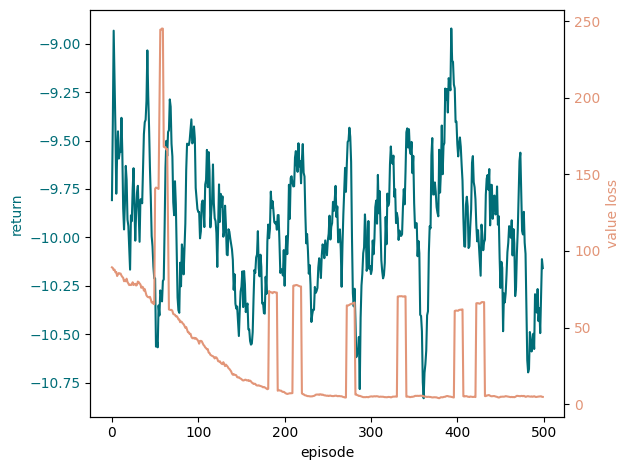

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def ma(x, window_len=10):
    res = list()
    for i in range(len(x)):
        if i < window_len:
            res.append(x[:i+1].mean())
        else:
            res.append(x[i-window_len:i].mean())
    return res

R = [r[0]for r in all_returns]
df = pd.DataFrame({
    'episode': np.arange(n_episodes),
    'returns': R,
    'value_loss': all_value_loss,
})
fig, ax1 = plt.subplots()
color = '#006d77'
ax1.set_xlabel('episode')
ax1.set_ylabel('return', color=color)
ax1.plot(df['episode'], ma(df['returns']), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = '#e29578'
ax2.set_ylabel('value loss', color=color)  # we already handled the x-label with ax1
ax2.plot(df['episode'], ma(df['value_loss']), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()